In [192]:
import cdsapi
import xarray as xr
import os
import geopandas as gpd
import numpy as np
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import shapely

plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

# Compliance Test Case Study

## Step 1: Download reference data

Data is the ERA5-Land Volumetric Soil Moisture Layer 1 data made by ECMWF through the Copernicus Programme.
 - [Link to data source](https://climate.copernicus.eu/esotc/2022/soil-moisture)

 **Dataset details**

 - Modeled soil moisture at `0-7cm` depth with units of $\frac{m^{3}}{m^{3}}$ (ratio of water volume to soil volume per cubic foot of earth)
 - `0.25` km resolution per `latitude` \ `longitude` grid cell coordinate
 - Hourly time resolution
 - Filtered to include `2016-2023` data for `January 31` of each year

In [193]:
c = cdsapi.Client()

for year in range(2016, 2023):
    c.retrieve(
        'reanalysis-era5-land',
        {
            'year': str(year),
            'month': '01',
            'day': '31',
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                6, 96, -11,
                142,
            ],
            "grid": [0.25, 0.25],
            'format': 'grib',
            'variable': [
                'volumetric_soil_water_layer_1',
            ],
        },
        'era5_volumetric_soil_moisture_layer_1-hourly-' + str(year) + '.grib')

2023-12-12 14:29:15,871 INFO Welcome to the CDS
2023-12-12 14:29:15,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-12-12 14:29:16,381 INFO Request is completed
2023-12-12 14:29:16,382 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/adaptor.mars.internal-1702344627.2431338-18958-18-7713c029-7eaa-48a5-a4f2-ff2abfee4157.grib to era5_volumetric_soil_moisture_layer_1-hourly-2016.grib (182.8K)
2023-12-12 14:29:18,289 INFO Download rate 95.9K/s 
2023-12-12 14:29:18,715 INFO Welcome to the CDS
2023-12-12 14:29:18,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-12-12 14:29:19,051 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data0/adaptor.mars.internal-1702344651.356733-1778-20-25aa264c-e3e9-4a54-ad27-07e9d2f479e6.grib to era5_volumetric_soil_moisture_layer_1-hourly-2017.grib (182.8K)
2023-12-

In [194]:
os.listdir()

['Meridia Reference Dataset.ipynb',
 'era5_volumetric_soil_moisture_layer_1-hourly-2018.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2022.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2019.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2020.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2016.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2017.grib',
 'era5_volumetric_soil_moisture_layer_1-hourly-2021.grib',
 '.ipynb_checkpoints',
 'scrap.py']

Combine each individual year dataset into a single dataset with all years

In [195]:
# List of file paths
file_paths = [
    'era5_volumetric_soil_moisture_layer_1-hourly-2018.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2022.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2019.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2020.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2016.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2017.grib',
    'era5_volumetric_soil_moisture_layer_1-hourly-2021.grib',
]

# Read in the files and concatenate them into a single dataset
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Sort the dataset by year, month, and day ascending
ds = ds.sortby(['time.year', 'time.month', 'time.day'])

# Print the dataset
ds


<xarray.Dataset>
Dimensions:              (time: 168, latitude: 69, longitude: 185)
Coordinates:
    number               int64 0
  * time                 (time) datetime64[ns] 2016-01-31 ... 2022-01-31T23:0...
    step                 timedelta64[ns] 00:00:00
    depthBelowLandLayer  float64 0.0
  * latitude             (latitude) float64 6.0 5.75 5.5 ... -10.5 -10.75 -11.0
  * longitude            (longitude) float64 96.0 96.25 96.5 ... 141.8 142.0
    valid_time           (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
Data variables:
    swvl1                (time, latitude, longitude) float32 dask.array<chunksize=(24, 69, 185), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-12-12T14:29 GRIB to CDM+CF via cfgrib-0.9.1...

## Step 2: Calculate 5 year rolling difference in average soil moisture

In this section a dataset is produced to calculate the difference in average soil moisture value over 5 years. The intent is to identify regions where soil quality is decreasing over time as an indicator of deforestation or other ecologically harmful practices taking place.

In [196]:
# Group the dataset by year and calculate the mean of swvl1
average_swvl1_by_year = ds.swvl1.groupby('time.year').mean()

average_swvl1_by_year


<xarray.DataArray 'swvl1' (year: 7, latitude: 69, longitude: 185)>
dask.array<stack, shape=(7, 69, 185), dtype=float32, chunksize=(1, 69, 185), chunktype=numpy.ndarray>
Coordinates:
    number               int64 0
    step                 timedelta64[ns] 00:00:00
    depthBelowLandLayer  float64 0.0
  * latitude             (latitude) float64 6.0 5.75 5.5 ... -10.5 -10.75 -11.0
  * longitude            (longitude) float64 96.0 96.25 96.5 ... 141.8 142.0
  * year                 (year) int64 2016 2017 2018 2019 2020 2021 2022
Attributes: (12/30)
    GRIB_paramId:                             39
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      12765
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           swvl1
    GRIB_totalNumber:                         0
    GRIB_units:                               m**3 m**-3
    long_name:                                Volumetric soil water layer 1
    units:                                    m**3 m**-3
    standard_name:                            unknown

In [197]:
running_difference = average_swvl1_by_year.rolling(year=5).mean().diff(dim='year')

# Print the dataset
running_difference

<xarray.DataArray 'swvl1' (year: 6, latitude: 69, longitude: 185)>
dask.array<sub, shape=(6, 69, 185), dtype=float32, chunksize=(4, 69, 185), chunktype=numpy.ndarray>
Coordinates:
    number               int64 0
    step                 timedelta64[ns] 00:00:00
    depthBelowLandLayer  float64 0.0
  * latitude             (latitude) float64 6.0 5.75 5.5 ... -10.5 -10.75 -11.0
  * longitude            (longitude) float64 96.0 96.25 96.5 ... 141.8 142.0
  * year                 (year) int64 2017 2018 2019 2020 2021 2022

In [198]:
running_difference_2022 = running_difference.sel(year=2022)
running_difference_2022

<xarray.DataArray 'swvl1' (latitude: 69, longitude: 185)>
dask.array<getitem, shape=(69, 185), dtype=float32, chunksize=(69, 185), chunktype=numpy.ndarray>
Coordinates:
    number               int64 0
    step                 timedelta64[ns] 00:00:00
    depthBelowLandLayer  float64 0.0
  * latitude             (latitude) float64 6.0 5.75 5.5 ... -10.5 -10.75 -11.0
  * longitude            (longitude) float64 96.0 96.25 96.5 ... 141.8 142.0
    year                 int64 2022

## Step 3: Visualize soil moisture change across the country

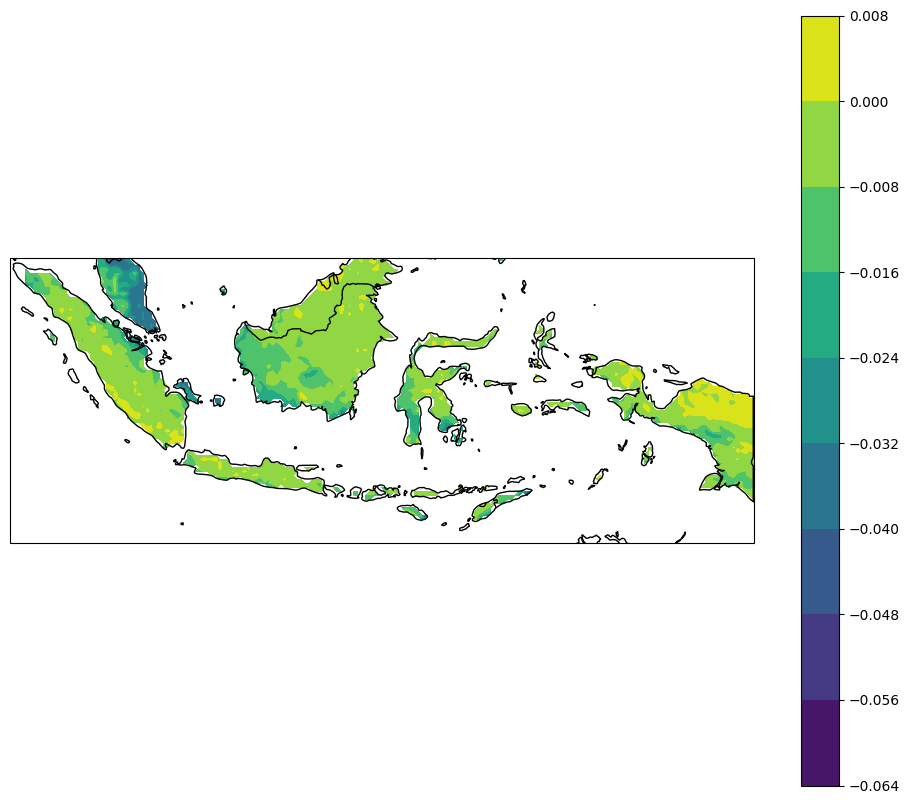

In [203]:
# Select the desired variable for the contour plot
# Indonesia
west = 95.0114
east = 141.0205
south = -10.9417
north = 5.9041

# east_zoom = 100.5
# west_zoom = 107.5
# south_zoom = -5.6667
# north_zoom = 5.05

# east_zoom = 105.3167
# west_zoom = 106.35
# south_zoom = -2.2167
# north_zoom = -1.55

# Create a figure and axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([west, east, south, north])

# Draw coastlines
ax.coastlines()

# Draw country boundaries
ax.add_feature(cartopy.feature.BORDERS)

# Create a contour plot
contour_plot = ax.contourf(running_difference_2022.longitude, running_difference_2022.latitude, running_difference_2022, transform=ccrs.PlateCarree())

# Add a colorbar

plt.colorbar(contour_plot)

# Show the map
plt.show()


## Step 4: Designing a compliance test script

This test will accept a latitude and longitude location, a reference dataset, and a threshold value. If the data returned from the reference dataset at the given location is less than the threshold amount, the location fails the test.

In [204]:
def volumetric_soil_moisture_test(point, reference_dataset, threshold = -0.01):
    """_summary_

    Args:
        point (_type_): _description_
        reference_dataset (_type_): _description_
        threshold (float, optional): _description_. Defaults to -0.01.
    """
    # Set latitude and longitude values for the point of interest
    latitude = point.y
    longitude = point.x

    # Create a GeoDataFrame from the xarray dataset
    gdf_dataset = reference_dataset.to_dataframe().reset_index()

    # Create Point geometries for each latitude and longitude pair in the dataset
    gdf_dataset['geometry'] = [Point(lon, lat) for lon, lat in zip(gdf_dataset['longitude'], gdf_dataset['latitude'])]

    # Select the data for the specified location
    data_at_location = reference_dataset.sel(latitude=latitude, longitude=longitude, method="nearest")

    # Print the data
    value = data_at_location.values

    if value < threshold:
        print("\u274c : Test failed for location ({}, {})".format(latitude, longitude))
        print("Change in volumetric soil moisture {} is below the threshold of {} at this location".format(value, threshold))
    else:
        print("\u2705 : Test passed for location ({}, {})".format(latitude, longitude))
        print("Change in volumetric soil moisture {} is above or equal to the threshold of {} at this location".format(value, threshold))

## Step 5: Run the test on two sample locations

Two separate farm collectives are included to run the test against. Because of the `0.25 km` resolution of the reference dataset this test is better suited for a cluster of farms in an area, and gives insight into macro outcomes resulting from total collective behavior of all nearby locations.

### Sample Farm Collective Location #1

In [201]:
# Sample Farm Collective #1
gdf_polygon = gpd.read_file("../data/sample-farm-01.geojson")

polygon = gdf_polygon['geometry'].iloc[0]
point = gdf_polygon['geometry'].iloc[1]

volumetric_soil_moisture_test(point, running_difference_2022, threshold=-0.01)


✅ : Test passed for location (-2.7166321863490737, 105.1214142044488)
Change in volumetric soil moisture -0.005921483039855957 is above or equal to the threshold of -0.01 at this location


### Sample Farm Collective Location #2

In [202]:
# Sample Farm Collective #2
gdf_polygon = gpd.read_file("../data/sample-farm-02.geojson")

polygon = gdf_polygon['geometry'].iloc[1]
point = gdf_polygon['geometry'].iloc[0]

volumetric_soil_moisture_test(point, running_difference_2022, threshold=-0.01)



❌ : Test failed for location (-2.4563003746718834, 105.59169464378448)
Change in volumetric soil moisture -0.014725565910339355 is below the threshold of -0.01 at this location
